### This code fills the "Emails" folder with folders named by date containing folders with each message, creates and saves a dataframe with each message and its date, adds financial data, trains a model, and makes a prediction based on today's emails

In [1]:
# Base Functions
import os
import pandas as pd
from bs4 import BeautifulSoup
import datetime
from datetime import datetime, timedelta, date
import pickle
import subprocess
import base64
from pandas import date_range
# Gmail API utilities
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
# For encoding/decoding messages in base64
from base64 import urlsafe_b64decode, urlsafe_b64encode
# For dealing with attachment MIME types
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.image import MIMEImage
from email.mime.audio import MIMEAudio
from email.mime.base import MIMEBase
from mimetypes import guess_type as guess_mime_type
# Functions for downloading financial data and algorithm training
from fredapi import Fred
from pandas_datareader import data as pdr
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import io
import sys
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
#%matplotlib inline

In [2]:
# Request all access (permission to read/send/receive emails, manage the inbox, and more)
SCOPES = ['https://mail.google.com/']
our_email = 'danjsabra@gmail.com'
FRED_key = 'da6657e10b059334f33e78245cfcb398'
fred = Fred(api_key = FRED_key)
# Fix dataframe display
pd.set_option("display.max_rows", None, "display.max_columns", None)
# Cleaning function
def clean(text):
    return "".join(c if c.isalnum() else "_" for c in text)

In [3]:
# Defining today for Email loading
today = str(date.today())
# Oldest date I could collect emails from
start_date = '2020-08-02'
# Creating a date range
range_dates = date_range(start = start_date, end = today)

In [4]:
# Function to convert pandas date range to pydatetime
def converter(date):
    return date.to_pydatetime().date()
# Applying date converter function to pydatetime range
date_list = list(map(converter, range_dates))

In [5]:
#Function to convert pydatetime range to clean string
def dater(date):
    return clean(str(date))
#Applying to date range
str_date_list = list(map(dater, date_list))

In [6]:
# Function to authenticate Gmail API
def gmail_authenticate():
    # The file token.pickle stores the user's access and refresh tokens, and is
    # created automatically when the authorization flow completes for the first time
    # Initialize "creds" to None
    creds = None
    # Check if "token.pickle" file exists, if so load "creds" from file
    if os.path.exists("token.pickle"):
        with open("token.pickle", "rb") as token:
            creds = pickle.load(token)
    # Check if "creds" is invalid or doesn't exist, if so check if expired or refresh token exists
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            # If refresh token exists, use it to refresh "creds"
            creds.refresh(Request())
        # If no refresh token, create "flow" from client secrets file, run and authorize "creds"
        else:
            flow = InstalledAppFlow.from_client_secrets_file('/Users/dansabra/Downloads/credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        # Save "creds" to "token.pickle" file
        with open("token.pickle", "wb") as token:
            pickle.dump(creds, token)
    # Return gmail service using "creds" for authentication
    return build('gmail', 'v1', credentials=creds)

In [7]:
# Get the gmail API service and ensure that the token saves to the correct folder
os.chdir('/Users/dansabra/Documents/Github/EmailsProject')
service = gmail_authenticate()

In [8]:
# Function to search for messages sent to gmail account
def search_messages(service, query):
    # Initialize a variable "result" to the result of search
    result = service.users().messages().list(userId='me',q=query).execute()
    # Emtpy list to store messages
    messages = [ ]
    # Check if the key "messages" is in the "result" object, and if so, add those messages to the "messages" list
    if 'messages' in result:
        messages.extend(result['messages'])
    # Check if the key "nextPageToken" is in the "result" object, indicating there are more pages of results
    while 'nextPageToken' in result:
        # While there are more pages, store the "nextPageToken" value in a variable "page_token"
        page_token = result['nextPageToken']
        # Run another search using new page_token
        result = service.users().messages().list(userId='me',q=query, pageToken=page_token).execute()
        # Check if the key "messages" is in the "result" object, and if so, add those messages to the "messages" list
        if 'messages' in result:
            messages.extend(result['messages'])
    # Return final messages list
    return messages

In [9]:
# Function get size format
def get_size_format(b, factor=1024, suffix="B"):
    # For loop to iterate over units of measurement
    for unit in ["", "K", "M", "G", "T", "P", "E", "Z"]:
        # Check if "b" is less than "factor", if true, return formatted string
        if b < factor:
            return f"{b:.2f}{unit}{suffix}"
        # Divide "b" by factor
        b /= factor
    # Return final formatted string with "b" and "Y" unit
    return f"{b:.2f}Y{suffix}"

In [10]:
# Function to clean text into tidy form
def clean(text):
    return "".join(c if c.isalnum() else "_" for c in text)

In [11]:
# Utility function to parse contents of email partitions
def parse_parts(service, parts, folder_name, message):
    # Check if there are parts in the email
    if parts:
        # Iterate through the parts
        for part in parts:
            # Extract the filename, mimeType, body, data, file size and headers from the part
            filename = part.get("filename")
            mimeType = part.get("mimeType")
            body = part.get("body")
            data = body.get("data")
            file_size = body.get("size")
            part_headers = part.get("headers")
            # Check if a part has more parts inside
            if part.get("parts"):
                # Recursively call the function for parts inside a part
                parse_parts(service, part.get("parts"), folder_name, message)
            # Check if the email part is plain text
            if mimeType == "text/plain":
                if data:
                    text = urlsafe_b64decode(data).decode()
                    print(text)
            # Check if the part is an HTML content
            elif mimeType == "text/html":
                if not filename:
                    filename = "index.html"
                # Save the HTML content to a file
                filepath = os.path.join(folder_name, filename)
                print("Saving HTML to", filepath)
                with open(filepath, "wb") as f:
                    f.write(urlsafe_b64decode(data))
            # For attachments other than a plain text or HTML, or attachment in header, save the attachment to a file
            else:
                # Looping through headers
                for part_header in part_headers:
                    # Extracting names and values
                    part_header_name = part_header.get("name")
                    part_header_value = part_header.get("value")
                    # Checl to see if current part of email is attachment
                    if part_header_name == "Content-Disposition":
                        if "attachment" in part_header_value:
                            print("Saving the file:", filename, "size:", get_size_format(file_size))
                            # Get the attachment ID 
                            attachment_id = body.get("attachmentId")
                            # Get the attachment
                            attachment = service.users().messages() \
                                        .attachments().get(id=attachment_id, userId='me', messageId=message['id']).execute()
                            data = attachment.get("data")
                            # Make filepath
                            filepath = os.path.join(folder_name, filename)
                            # Check if data is there
                            if data:
                                # Save data to filepath in binary
                                with open(filepath, "wb") as f:
                                    f.write(urlsafe_b64decode(data))

In [12]:
# Function to add attachment to a message
def add_attachment(message, filename):
    # Initialize variables 'content_type' and 'encoding'
    content_type, encoding = guess_mime_type(filename)
    # Check content type and encoding
    if content_type is None or encoding is not None:
        content_type = 'application/octet-stream'
    # Split content type into parts
    main_type, sub_type = content_type.split('/', 1)
    # If type is text, create MIMEText object
    if main_type == 'text':
        fp = open(filename, 'rb')
        msg = MIMEText(fp.read().decode(), _subtype=sub_type)
        fp.close()
    # If type is image, create MIMEImage object
    elif main_type == 'image':
        fp = open(filename, 'rb')
        msg = MIMEImage(fp.read(), _subtype=sub_type)
        fp.close()
    # If type is audio, create MIMEAudio object
    elif main_type == 'audio':
        fp = open(filename, 'rb')
        msg = MIMEAudio(fp.read(), _subtype=sub_type)
        fp.close()
    # If type is base, create MIMEBase object
    else:
        fp = open(filename, 'rb')
        msg = MIMEBase(main_type, sub_type)
        msg.set_payload(fp.read())
        fp.close()
    # Set filename variable to base name of provided filename
    filename = os.path.basename(filename)
    # Add header 
    msg.add_header('Content-Disposition', 'attachment', filename=filename)
    # Attach message
    message.attach(msg)

In [13]:
# Function to build a message
def build_message(destination, obj, body, attachments=[]):
    # Message starts as MIMEMultipart
    message = MIMEMultipart()
    # Specify subject and who message is to/from
    message['to'] = destination
    message['from'] = our_email
    message['subject'] = obj
    # Add MIMEText
    message.attach(MIMEText(body, 'html'))
    # Add images
    for y in MIMEImages:
        message.attach(y)
    # Add attachments
    for filename in attachments:
        add_attachment(message, filename)
    # Return encoded message
    return {'raw': urlsafe_b64encode(message.as_bytes()).decode()}

In [14]:
# Function to send a message
def send_message(service, destination, obj, body, attachments=[]):
    # Return details of message, sent mainly using build_message and .send methods
    return service.users().messages().send(
      userId="me",
      body=build_message(destination, obj, body, attachments)
    ).execute()

In [15]:
# Function to create folder in "Emails" named by date which contains subfolders named subjects of emails
def filler(service, message, date):
    # Retrieve messages
    msg = service.users().messages().get(userId='me', id=message['id'], format='full').execute()
    # Obtain payload
    payload = msg['payload']
    # Use payload to get headers and parts
    headers = payload.get("headers")
    parts = payload.get("parts")
    # Define folder name
    folder_name = "email"
    # Initiate has_subject
    has_subject = False
    # Check for headers
    if headers:
        # Loop through headers
        for header in headers:
            # Obtain header names and values
            name = header.get("name")
            value = header.get("value")
            # Print to and from values
            if name.lower() == 'from':
                print("From:", value)
            if name.lower() == "to":
                print("To:", value)
            # Check for subject
            if name.lower() == "subject":
                has_subject = True
                # Define folder name
                folder_name = clean(value)
                # Start folder counter
                folder_counter = 0
                # While loop for while open directory is folder of each message
                while os.path.isdir('/Users/dansabra/Documents/GitHub/EmailsProject/Emails/' + date + '/' + folder_name):
                    # Add to folder counter
                    folder_counter += 1
                    # Check if foldername has already been a duplicate to change number at end
                    # if messages have same subject
                    if folder_name[-1].isdigit() and folder_name[-2] == "_":
                        folder_name = f"{folder_name[:-2]}_{folder_counter}"
                    elif folder_name[-2:].isdigit() and folder_name[-3] == "_":
                        folder_name = f"{folder_name[:-3]}_{folder_counter}"
                    else:
                        folder_name = f"{folder_name}_{folder_counter}"
                # Define parent directory
                parent_dir = '/Users/dansabra/Documents/GitHub/EmailsProject/Emails/' + date
                # Define path
                path = os.path.join(parent_dir,folder_name)
                # Make path
                os.mkdir(path)
                print("Subject:", value)
            if name.lower() == "date":
                print("Date:", value)
    # If no subject
    if not has_subject:
        if not os.path.isdir(folder_name):
            os.mkdir(folder_name)
    # Utilize parse_parts function
    parse_parts(service, parts, path, message)

In [16]:
# Function to read html that emails are currently stored in and convert them to readable python strings,
# While also (***crucially***) filtering out repetitive language or phrases in the messages that may confuse
# The model during training
def souper(html):
    # Creating beautiful soup object
    soup = BeautifulSoup(html, features="html.parser")
    # Looping through object
    for script in soup(["script", "style"]):
        # Rip
        script.extract()    
    # Get text
    text = soup.get_text()
    # Get lines
    lines = (line.strip() for line in text.splitlines())
    # Move to chunks
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    # Put it back together
    text = '\n'.join(chunk for chunk in chunks if chunk)
    # Define phrases to filter out
    trashphrases = ['@CFOJournal, @kcbroughton, @markgmaurer, @Nina_Trentmann and @JenKayW.',' ›  | ','Read MoreAdd this information to your WSJ watchlist','SB11556170674100694698904589013090691590278','For further assistance, please contact Customer Service atsupport@wsj.comor 1-800-JOURNAL.','To manage your notifications visit thealerts center.','Newsletters & Alerts|Contact Us|Privacy Notice|Cookie Notice .','Keith Collinsin Hong Kong','ForwardLEAVE THIS BOX EMPTY',' . | ','CFO Journal\'s bureau chief, Nina Trentmann, can be reached at nina.trentmann@wsj.com.','About us @CFOJournal, @kcbroughton, @markgmaurer, @Nina_Trentmann and @JenKayW.','   and    . | ','Jeff Sparshott here with the latest on the economy.','Copyright2022Dow Jones & Company, Inc.','Today\'s issue was curated and edited by','Miguel Gonzalez (@gonzowsj) in Washington, D.C.','Special edition of The Wall Street Journal\'s economics newsletter.','Forward ›  . | ','Forward › › . | ','This newsletter is written and edited byCaitlin Ostroff (@ceostroff;caitlin.ostroff@wsj.com) in London. . | ','I\'m Caitlin Ostroff, here to get you started for the week.','Today\'s issue was curated and edited by  and  in Washington, D.C., and.How are we doing?  Thank you. . | ','Jeff Sparshott (@jeffsparshott)','You can send questions, comments and suggestions by replying to this email.','This is Jeff Sparshott with the latest on the economy.','WSJ Pro\'s deputy editor, Brian Hershberg, can be reached at brian.hershberg@wsj.com.','About us @WSJCFO, @kcbroughton, @markgmaurerand @JenKayW.','Keith Collins in Hong Kong','Sarah Chackoin North Carolina','Your guide to the day’s news exclusively for Wall Street Journal members.','A guide to the day’s top news','ForwardLEAVE THIS BOX EMPTY . |','All Rights Reserved.Unsubscribe','Copyright2023Dow Jones & Company, Inc.','Breaking news from The Wall Street Journal.','Please feel free to offer me your feedback by replying directly to this email.','Unsubscribe|Newsletters & Alerts|Contact Us|Privacy Notice|Cookie Notice','To manage your notifications visit theAlerts Center','Share your news tips and feedback by replying to this email.','Follow the Heard Column on Twitter at @WSJheard.','Follow her on Twitter at @TelisDemos.','The latest from the WSJ\'s Heard on the Street team','Today\'s newsletter was curated by , in collaboration with colleagues in New York.','Eleanor Millerin Washington, D.C.','See our comment guidelines.','The 10-Point was the name given to the news column on the WSJ\'s front page.','If someone forwarded you this email, we invite you to join us.','About us @CFOJournal, @kcbroughton, @markgmaurer and @Nina_Trentmann.CFO Journal\'s bureau chief, Nina Trentmann, can be reached at nina.trentmann@wsj.com.','SubscribeUnsubscribe|Newsletters & Alerts|Contact Us|Privacy Policy|Cookie Policy','Follow the CFO Journal team on Twitter:','Kristin Broughton contributed to today\'s Ledger.','We hope you’re enjoying Notes on the News.','If you would prefer to receive a different newsletter, please check out all your options to keep up with the latest on markets, economics, politics and more. For members, we recommend The 10-Point..Forward › ›  .','Copyright2021Dow Jones & Company, Inc. | All Rights Reserved.Unsubscribe','You are currently subscribed as danjsabra@gmail.com','North Monmouth Junction, NJ 08852','Forwarded this email by a friend?Sign Up Here','\u200f','\u200e','Good afternoon and welcome to Notes on the News.','Today’s headlines, news in context, and good reads you may have missed','The week ahead, the news of the day in context and good reads you may have missed.','Tracy Ganin Hong Kong',' .  Today\'s issue was curated and edited by , ,and  and  in Washington, D.C.How are we doing?  Thank you. ','Jeff Sparshott (@jeffsparshott) in Manila','Jeff Sparshott here to take you through key developments in the global economy.','Today\'s guide to the WSJGood Morning.','Adam Martin in Hong Kong','Josh Mitchell(JMitchellWSJ)','in collaboration with Editor in Chief Matt Murray.','William Westbrook in Hong Kong','Sarah Chackoin New York','Today’s newsletter was curated and edited by','We want to be the first place you go to get ready for the opening bell every day.','Today’s newsletter was curated and edited by Sarah Chackoin New York and Keith Collinsin Hong Kong in collaboration with Editor in Chief Matt Murray.','What Else We\'re Reading',' .  , ,and , and  in Washington, D.C.How are we doing?  Thank you. ','Becky Bowers (@beckybowers)','Josh Mitchell (@JMitchellWSJ)','Greg Ip (@greg_ip)','Good morning.','Josh Mitchell here to take you through key developments in the global economy.','Send us your questions, comments and suggestions by replying to this email.','and Chris Wellisz (@wellisz)in Washington, D.C.','and Greg Ip (@greg_ip)','This newsletter is written and edited byJames Willhite (@jimwillhite; james.willhite@wsj.com) in London.','About Us','Sign Up for Our Calendar has launched a downloadable calendar with concise previews, forecasts and analysis of major U.S. data releases.','comes to you from WSJ economics reporters and editors around the world.','Real Time Economics','Your daily economics newsletter from The Wall Street Journal.','Today’s newsletter was curated and edited by Sarah Chackoin New York and Adam Martin in Hong Kong in collaboration with Editor in Chief Matt Murray.','About UsWe want to be the first place you go to get ready for the opening bell every day. This newsletter is written and edited byJames Willhite (@jimwillhite; james.willhite@wsj.com) in London. ',' , ,.How are we doing?  Thank you. ','Please send us any questions, comments or suggestions by replying to this email.','and Greg Ip (@greg_ip) and Becky Bowers (@beckybowers) in Washington, D.C','James Hookway (@JamesHookway) in London','Today\'s issue was curated and edited by Jeff Sparshott (@jeffsparshott) in Madrid','About UsReal Time Economics comes to you from WSJ economics reporters and editors around the world.','ForwardForwarded this email by a friend?Sign Up HereLEAVE THIS BOX EMPTY ','North Monmouth Junction, NJ 08852.','The 10-Point was the name given to the news column that runs on the front page of The Wall Street Journal.',' For further assistance,  or 1-800-JOURNAL.','Let us know what you think by replying to this email.','Access WSJ.com and our mobile apps.','Copyright2020Dow Jones & Company, Inc. | All Rights Reserved.Unsubscribe','If someone forwarded you this email, we invite you to join us and enjoy the full breadth of scoops, analysis and great storytelling from our journalists around the globe.','The 10-Point is a WSJ member benefit.','Today’s newsletter was curated and edited by Sarah Chackoin New York and Tracy Ganin Hong Kong in collaboration with Editor in Chief Matt Murray.','Question for the next 10-Point:','Email us your comments, which we may edit or shorten before publication, to 10point@wsj.com, and make sure to include your first and last name and location. See our comment guidelines here.','The 10-Point was the name given to the news column that runs on the front page of The Wall Street Journal.Today’s newsletter was curated and edited by Sarah Chackoin New York and Adam Martin in Hong Kong in collaboration with Editor in Chief Matt Murray.Let us know what you think by replying to this email.The 10-Point is a WSJ member benefit. If someone forwarded you this email, we invite you to join us and enjoy the full breadth of scoops, analysis and great storytelling from our journalists around the globe.Access WSJ.com and our mobile apps. North Monmouth Junction, NJ 08852. For further assistance,  or 1-800-JOURNAL.Copyright2020Dow Jones & Company, Inc. | All Rights Reserved.Unsubscribe',' and I\'d like to welcome everyone who previously received The Daily Shot newsletter. You\'ll get exclusive analysis, key stocks to watch for the day, surprising facts and a new feature, Data Watch, showcasing the figures driving markets.Please share your thoughts by replying to this email. If you\'d rather not receive it, you can always opt out using the link at the bottom of each edition.','About UsWe want to be the first place you go to get ready for the opening bell every day. This newsletter is written and edited byJames Willhite (@jimwillhite; james.willhite@wsj.com) in London.Access WSJ.com and our mobile apps. North Monmouth Junction, NJ 08852. For further assistance,  or 1-800-JOURNAL.Copyright2020Dow Jones & Company, Inc. | All Rights Reserved.Unsubscribe','A pre-markets primer packed with market updates, insights and must-read news links. ›MarketsHello. I\'m James Willhite,',' ›.','›Markets Alert','Sign Up for Our CalendarReal Time Economics has launched a downloadable calendar with concise previews, forecasts and analysis of major U.S. data releases. .','About UsReal Time Economics comes to you from WSJ economics reporters and editors around the world. Today\'s issue was curated and edited by Jeff Sparshott (@jeffsparshott) in Madrid, James Hookway (@JamesHookway) in London,and Greg Ip (@greg_ip) and Becky Bowers (@beckybowers) in Washington, D.C.How are we doing? Please send us any questions, comments or suggestions by replying to this email. Thank you.Access WSJ.com and our mobile apps. North Monmouth Junction, NJ 08852. For further assistance,  or 1-800-JOURNAL.Copyright2020Dow Jones & Company, Inc. | All Rights Reserved.Unsubscribe','Your daily economics newsletter from The Wall Street Journal. ›Real Time EconomicsGood morning. Jeff Sparshott here to take you through key developments in the global economy. Send us your questions, comments and suggestions by replying to this email.','See our comment guidelines here.The 10-Point was the name given to the news column that runs on the front page of The Wall Street Journal.Today’s newsletter was curated and edited by Sarah Chackoin New York and William Westbrook in Hong Kong in collaboration with Editor in Chief Matt Murray.Let us know what you think by replying to this email.The 10-Point is a WSJ member benefit. If someone forwarded you this email, we invite you to join us and enjoy the full breadth of scoops, analysis and great storytelling from our journalists around the globe.Access WSJ.com and our mobile apps. North Monmouth Junction, NJ 08852. For further assistance,  or 1-800-JOURNAL.Copyright2020Dow Jones & Company, Inc. | All Rights Reserved.Unsubscribe','Read MoreRead WSJ\'s latest headlines','\xa0','\u200c','\n','ForwardForwarded this email by a friend?Sign Up HereLEAVE THIS BOX EMPTYAccess WSJ.com and our mobile apps. North Monmouth Junction, NJ 08852. For further assistance,  or 1-800-JOURNAL.Copyright2020Dow Jones & Company, Inc. | All Rights Reserved.Unsubscribe','Dow Jones & Company, Inc. 4300 U.S. Route 1','please contact Customer Service at support@wsj.com','Share this email with a friend','You are currently subscribed as dan.sabra@sstx.org','SubscribeUnsubscribe|Newsletters & Alerts|Contact Us|Privacy Notice|Cookie Notice','Trouble viewing this email? View in web browser','To add to your calendar, please click here','About UsReal Time Economics comes to you from WSJ economics reporters and editors around the world. Today\'s issue was curated and edited by Jeff Sparshott (@jeffsparshott) in Madrid, James Hookway (@JamesHookway) in London,and Greg Ip (@greg_ip) and Becky Bowers (@beckybowers) in Washington, D.C.How are we doing? Please send us any questions, comments or suggestions by replying to this email. Thank you.Access WSJ.com and our mobile apps.SubscribeUnsubscribe|Newsletters & Alerts|Contact Us|Privacy Notice|Cookie NoticeDow Jones & Company, Inc. 4300 U.S. Route 1 North Monmouth Junction, NJ 08852You are currently subscribed as dan.sabra@sstx.org. For further assistance, please contact Customer Service at support@wsj.com or 1-800-JOURNAL.Copyright2020Dow Jones & Company, Inc. | All Rights Reserved.Unsubscribe','Your daily economics newsletter from The Wall Street Journal.Trouble viewing this email? View in web browser','Let us know what you think by replying to this email.The 10-Point is a WSJ member benefit. If someone forwarded you this email, we invite you to join us and enjoy the full breadth of scoops, analysis and great storytelling from our journalists around the globe.Access WSJ.com and our mobile apps.SubscribeUnsubscribe|Newsletters & Alerts|Contact Us|Privacy Notice|Cookie NoticeDow Jones & Company, Inc. 4300 U.S. Route 1 North Monmouth Junction, NJ 08852You are currently subscribed as dan.sabra@sstx.org. For further assistance, please contact Customer Service at support@wsj.com or 1-800-JOURNAL.Copyright2020Dow Jones & Company, Inc. | All Rights Reserved.Unsubscribe','About UsWe want to be the first place you go to get ready for the opening bell every day. This newsletter is written and edited byJames Willhite (@jimwillhite; james.willhite@wsj.com) in London.Access WSJ.com and our mobile apps.SubscribeUnsubscribe|Newsletters & Alerts|Contact Us|Privacy Notice|Cookie NoticeDow Jones & Company, Inc. 4300 U.S. Route 1 North Monmouth Junction, NJ 08852You are currently subscribed as dan.sabra@sstx.org. For further assistance, please contact Customer Service at support@wsj.com or 1-800-JOURNAL.Copyright2020Dow Jones & Company, Inc. | All Rights Reserved.Unsubscribe','A pre-markets primer packed with market updates, insights and must-read news links.Trouble viewing this email? View in web browser ›Markets']
    for i in range(100):
        for trash in trashphrases:
            text = text.replace(trash,'')
    return text

In [17]:
# Function to create keys in a dictionary equal to each date in a date range where the respective values
# Are a list of each message (in cleaned form) that was sent that day
def data_adder(date_list):
    # Create empty dictionary
    dictionary = {}
    # Loop through date list
    for date in date_list:
        # Define name for each key
        holder = "X" + clean(str(date))
        # Create empty list as value for each key
        dictionary[holder] = []
        # Define base file path
        base_path = '/Users/dansabra/Documents/GitHub/EmailsProject/Emails/' + clean(str(date))+'/'
        # Navigate to path
        os.chdir(base_path)
        # List subfolders for each date folder
        endpoints = os.listdir()
        # Loop through subfolders (named subject of each email received on date)
        for z in endpoints:
            if z == ".DS_Store":
                continue
            # Navigate to subfolder
            os.chdir(base_path+z)
            # If subfolder is empty, continue
            if len(os.listdir()) == 0:
                continue
            else:
                # Read index object and save to html
                html = open("index.html", "r").read()
                # Use souper function to read the html, and save output to dictionary
                dictionary[holder].append(souper(html))
    return dictionary

In [18]:
# Function to request data from messages with gmail API
def requester(date):
    # Define before and after dates to isolate one specific day
    before = "before: " + str(date + timedelta(1))
    after = "after:" + str(date) + ','
    # Save results to variable
    results = search_messages(service, before + after + filters)
    # Apply filler function
    for msg in results:
        filler(service, msg, clean(str(date)))

In [19]:
# Filtering messages to only come from WSJ or NYT - trouble with bloomberg
filters = "from: access@interactive.wsj.com OR from: nytdirect@nytimes.com"

In [20]:
# Navigating to "Emails" folder before loading data
base_path1 = '/Users/dansabra/Documents/GitHub/EmailsProject/Emails'
os.chdir(base_path1)

In [21]:
# Looping through previously defined date range to create a folder in the "Emails" folder for each date,
# but continues if the folder already exists
for x in date_list:
    # Continue if messages have already been added
    if clean(str(x)) in os.listdir():
        continue
    else:
        path = os.path.join(base_path1, clean(str(x)))
        os.mkdir(path)
        requester(x)

In [22]:
# Converting date list to string form
def stringer(date):
    return clean(str(date))
date_list = list(map(stringer, date_list))

### At this point, the 'Emails' folder has been filled. The next step will be to create a dataframe.

In [23]:
# Changing working directory to "Emails" folder
os.chdir('/Users/dansabra/Documents/GitHub/EmailsProject/Emails')

In [24]:
# See if dictionary ('final') has already been created
if os.path.exists('/Users/dansabra/Documents/GitHub/EmailsProject/final.pkl'):
# If it does, open it, and make the value of final equal to it
    with open('/Users/dansabra/Documents/GitHub/EmailsProject/final.pkl','rb') as f:
        final = pickle.load(f)
# If it doesn't exist
else:
    # Create the dictionary
    final = data_adder(date_list)
    # Save it
    with open('/Users/dansabra/Documents/GitHub/EmailsProject/final.pkl','wb') as f:
        pickle.dump(final,f)

In [26]:
# Finding which dates aren't in dictionary yet
dict_dates = [string[1:] for string in list(final.keys())]
not_included = []
for date in str_date_list:
    if date not in dict_dates:
        not_included.append(date)
# Make a dictionary with dates not included
not_included_dict = data_adder(not_included)
# Add this to main dictionary
final.update(not_included_dict)
# Save dictionary
with open('/Users/dansabra/Documents/GitHub/EmailsProject/final.pkl','wb') as f:
    pickle.dump(final,f)

In [27]:
# Function to convert a dictionary to a dataframe
def creator(date_list):
    empty_dates = []
    empty_texts = []
    for date in date_list:
        path = "X" + date
        for text in final[path]:
            empty_texts.append(text)
        for i in range(len(final[path])):
            empty_dates.append(date)  
    dataframe = pd.DataFrame()
    dataframe['Date'] = empty_dates
    dataframe['Text'] = empty_texts
    return dataframe

In [28]:
# Converting the above dictionary to a dataframe
textframe = creator(date_list)

### We now have a dataframe with every message and its date. Next, we will add financial data, train a model, and make predictions

In [29]:
# Defining today
from datetime import date
today = date.today()
# Calling today's messages into a list
newmessageslist = final['X'+stringer(today)]
# Combining all of todays messages into a single string for future use
newmessages = ''.join(newmessageslist)
# Placing single string into list for compatibality with previously written functions
todays_texts = [newmessages]

In [30]:
# Creating a class that can download data on a security from yahoo finance, train a model to predict its overnight
# movement using the downloaded emails, and return details about the model
class Trainer:
    # Initiating class
    def __init__(self, yahoo_ticker):
        self.yahoo_ticker = yahoo_ticker
    # Function to return a dataframe with financial information alongside with each message
    def framemaker(self):
        # Overriding data readers to make it compatible with yahoo finance
        yf.pdr_override()
        # Downloading the price history of the security with the same range as messages in text frame
        data = pdr.get_data_yahoo(self.yahoo_ticker, start=date_list[0].replace('_','-'), end=date_list[-1].replace('_','-'))
        # Creating list to store converted dates
        str_dates = []
        # Filling list with converted dates
        for x in data.index:
            str_dates.append(x.strftime("%Y_%m_%d"))
        # Adding new datelist to dataframe
        data['str_dates'] = str_dates
        # Getting rid of all unnecessary columns
        data = data[['Open','Close','str_dates']]
        # Resetting index
        data = data.reset_index(drop=True)
        # Function to calulate the percentage overnight change in the selected security's price for each message
        def overnighter(date):
            # Cannot calculate overnight change of security's price for messages from earliest date
            if date == data['str_dates'][0]:
                return "N/A"
            else:
                # Finding index of all messages that match a certain date
                today_index = data.index[data['str_dates'] == date]
                # Finding opening prices of security for each message
                today_open = data[data['str_dates'] == date]['Open'][today_index].tolist()[0]
                # Finding previous closing price of security for each message
                last_close = data.loc[today_index - 1]['Close'][today_index - 1].tolist()[0]
                # Returning the percentage change of each security overnight
                return ((today_open - last_close)/last_close) * 100
        # Adding % overnight change in selected security's price (dep. variable) for each message (ind. variable)
        data['Change'] = data['str_dates'].apply(overnighter)
        #####
        data = data.drop(data.index[0])
        def Transfer(date):
            # If there is no data for opening or close price, return that the market was closed
            if len(list(data[data['str_dates'] == date]['Open'].tolist())) == 0:
                return ["Closed","Closed","Closed","Closed"]
            # If there is data, return each aspect of it (mainly for purpose of filterin out closed dates)
            else:
                return [data[data['str_dates'] == date][x].tolist()[0] for x in data[data['str_dates'] == date]]
        # Renaming textframe
        newframe = textframe
        # Applying Transfer function based off of Date
        newframe[['Open','Close','dates','Change']] = newframe['Date'].apply(lambda x: pd.Series(Transfer(x)))
        # Removing unncessary columns
        newframe = newframe[['Date','Text','Open','Close','Change']]
        # Removing all messages from dates when the market was closed
        finalframe = newframe[newframe.Open != 'Closed']
        # Defining an arbitrary cutoff value to remove all statistically insignificant market moves
        cutoff = .25
        # Removing all values below cutoff
        finalframe = finalframe[(finalframe['Change'] > cutoff) | (finalframe['Change'] < (cutoff * -1))]
        # Returns a frame with each message, its date, and the open, close, and % change of the security price
        return finalframe
    
    def modeler(self):
        # Removing every column except the message (independent variable) and overnight change (dependent variable)
        data = self.framemaker()[['Text','Change']]
        # Splitting data into training and testing samples based off of the price change
        training_sample, testing_sample = train_test_split(data['Change'], random_state=0)
        training = data[data.index.isin(training_sample.index)]
        testing = data[data.index.isin(testing_sample.index)]
        # Converting messages and outcomes in training and testing samples to lists
        training_text, training_values = training.Text.tolist(), training.Change.tolist()
        testing_text, testing_values = testing.Text.tolist(), testing.Change.tolist()
        # Vectorizing the messages in the training sample to build word library
        vectorizer = CountVectorizer().fit(training_text)
        # Counting occurrences of each word in word library in training and testing sample
        training_text_vect = vectorizer.transform(training_text)
        testing_text_vect = vectorizer.transform(testing_text)
        # Defining ridge regression model
        ridge = Ridge(alpha=450)
        # Fitting model to vectorized training texts against respective price change values
        ridge.fit(training_text_vect, training_values)
        # Listing predictions for price change based off of each message for training and testing sample
        training_predictions = list(ridge.predict(training_text_vect))
        testing_predictions = list(ridge.predict(testing_text_vect))
        # Defining MSE's for training and testing samples
        training_MSE = mean_squared_error(training_values, training_predictions)
        testing_MSE = mean_squared_error(testing_values, testing_predictions)
        # Defining r2 scores for traindng and testing samples
        training_r2 = r2_score(training_values, training_predictions)
        testing_r2 = r2_score(testing_values, testing_predictions)
        # Returning the word library, model, and r2
        return vectorizer, ridge, testing_r2
        # print('Training:\n' + 'MSE:' + str(round(training_MSE,3))+'\n'+'r2:' + str(round(training_r2,3)) + '\n\n'+
        #'Testing:\n' + 'MSE:'+str(round(testing_MSE,3))+'\nr2:'+str(round(testing_r2,3)))

In [31]:
# List of securities to be analyzed
comboslist = [['^GSPC','S&P 500'],['^IXIC','NASDAQ'],['^TNX','10Y UST'],['EUR=X','EURUSD']]

In [32]:
# Dataframe to store results of model on each security
outcomesframe = pd.DataFrame(columns=['Name','Prediction','r squared'])

In [33]:
# Function to train a model for a security and make a prediction given todays messages
def creator(ticker):
    # Getting word library, trained model, and r2 score for each security
    modeler_outcome = Trainer(ticker[0]).modeler()
    # Assigning above listed values to variables
    vectorizer = modeler_outcome[0]
    model = modeler_outcome[1]
    rsquared = modeler_outcome[2]
    # Counting how many times each word in word library appears in all of todays messages
    new = vectorizer.transform(todays_texts)
    # Predicting overnight price change from todays messages
    outcome = round(float(model.predict(new)),3)
    # Organizing redults
    values = ticker[1], outcome, rsquared
    # Returns single price change prediction for each security given todays messages
    return values

In [34]:
# Training models and making predictions for each security in tickers list, then adding to dataframe
for combo in comboslist:
    values = creator(combo)
    outcomesframe = outcomesframe.append(pd.Series(values, index=outcomesframe.columns), ignore_index=True)

[*********************100%***********************]  1 of 1 completed


/var/folders/3g/lmg4c_3972zdk1mkgwq6qhk80000gn/T/ipykernel_77685/2685996890.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outcomesframe = outcomesframe.append(pd.Series(values, index=outcomesframe.columns), ignore_index=True)


[*********************100%***********************]  1 of 1 completed


/var/folders/3g/lmg4c_3972zdk1mkgwq6qhk80000gn/T/ipykernel_77685/2685996890.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outcomesframe = outcomesframe.append(pd.Series(values, index=outcomesframe.columns), ignore_index=True)


[*********************100%***********************]  1 of 1 completed


/var/folders/3g/lmg4c_3972zdk1mkgwq6qhk80000gn/T/ipykernel_77685/2685996890.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outcomesframe = outcomesframe.append(pd.Series(values, index=outcomesframe.columns), ignore_index=True)


[*********************100%***********************]  1 of 1 completed


/var/folders/3g/lmg4c_3972zdk1mkgwq6qhk80000gn/T/ipykernel_77685/2685996890.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outcomesframe = outcomesframe.append(pd.Series(values, index=outcomesframe.columns), ignore_index=True)


### Now, we will construct the email and also add useful graphs to see in the morning

In [35]:
# Function to return greater or less than
def glt(outcome):
    if outcome > 0:
        return " greater than"
    if outcome < 0:
        return " less than"
    else:
        return "equal"

In [36]:
# Function to find day of week, then saving to variable
import datetime
def day_finder():
    return datetime.datetime.now().strftime('%A')
day = day_finder()

In [37]:
# Defining how far back graph dates should go and how rotated dates should be
days_back = 50
rotation = 45

In [38]:
# Changing directory to ensure images are downloaded to correct folder
os.chdir('/Users/dansabra/Documents/GitHub/EmailsProject/Images')

In [39]:
# Defining start and end dates for data to be used in graphs
startdate = (date.today() - timedelta(days_back))
enddate = date.today()

In [40]:
# Function to create graph for a ticker, label it by given name, then save it for future use from yahoo
def imager(combo):
    # Overriding data readers to make it compatible with yahoo finance
    yf.pdr_override()
    # Saving given ticker to variable
    ticker = combo[0]
    # Saving given name to variable
    name = combo[1]
    # Graphs of currencies (all contain USD here) look better in 1d interval over 60m
    if 'USD' or 'Bitcoin' in name:
        interval = '1d'
    else:
        interval = '60m'
    # Downloading data for given ticker with specified parameters
    data = pdr.get_data_yahoo(ticker, start=startdate, end=enddate, interval = interval)
    # Converting dates to shorter form for neatness in graph output
    data.index = data.index.strftime('%m-%d')
    # Creating values equal to invert in case of improperly presented currency price
    data['copy'] = data['Close'].apply(lambda x: 1/x)
    # Temporary string value
    inverter = 'blank'
    # Need to use inverted value for Euro
    if 'EUR' in name:
        inverter = 'copy'
    else:
        inverter = 'Close'
    # Resetting graph to not plot each security on one graph
    plt.figure()
    # Plotting data
    plt.plot(data.index,data[inverter])
    # Setting date rotation
    plt.xticks(rotation=45)
    # Minimizing number of dates
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
    # Labelling graph
    plt.suptitle(name)
    # Removing spaces from name
    name = name.replace(" ","")
    # Saving image
    plt.savefig(name)

In [41]:
# List of yahoo tickers and names to be used in message
comboslist = [['BTC-USD','Bitcoin'],['NG=F','Natural Gas'],['USDAUD=X','USDAUD'],['GBPUSD=X','GBPUSD'],['CDX','Simplify HY'],['000001.SS','Shanghai Composite Index'],['VGK','Vanguard European Stock Index'],['^GSPC', 'S&P 500'],['^IXIC','NASDAQ'],['^TNX','10Y UST'],['EUR=X','EURUSD'],['JPY=X','USDJPY'],['XBM.TO','Base Metals Index']]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


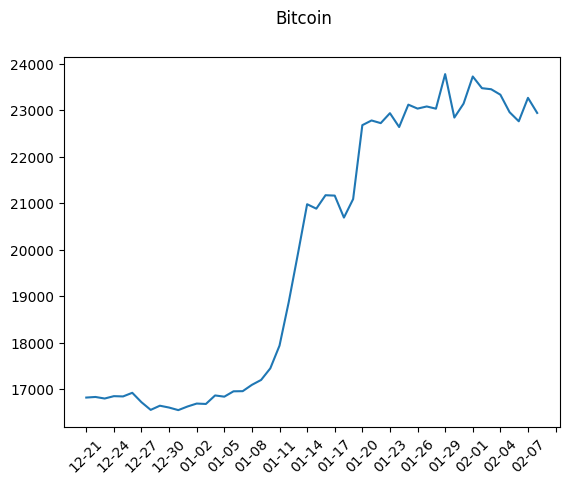

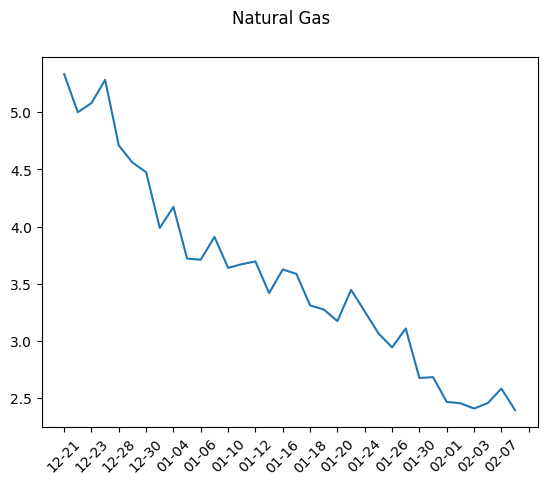

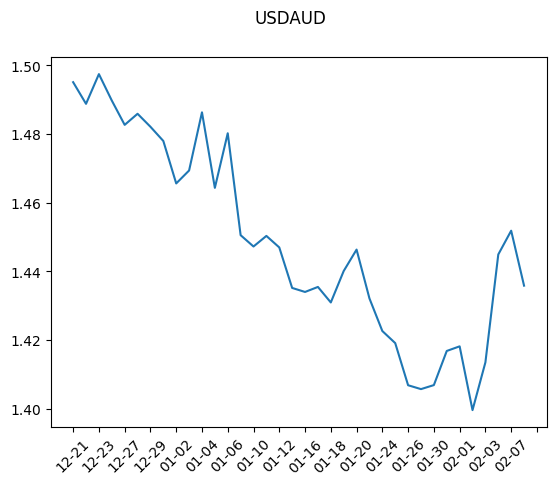

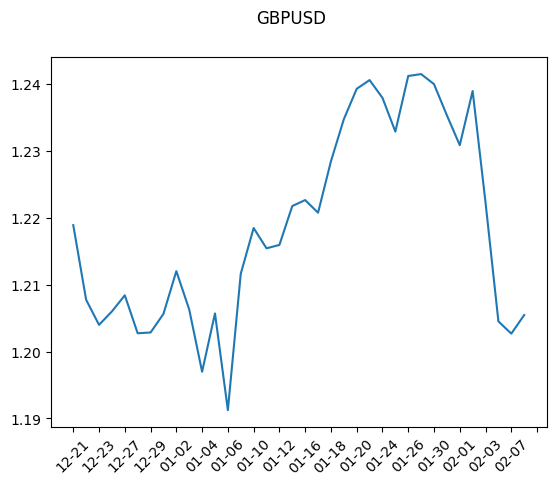

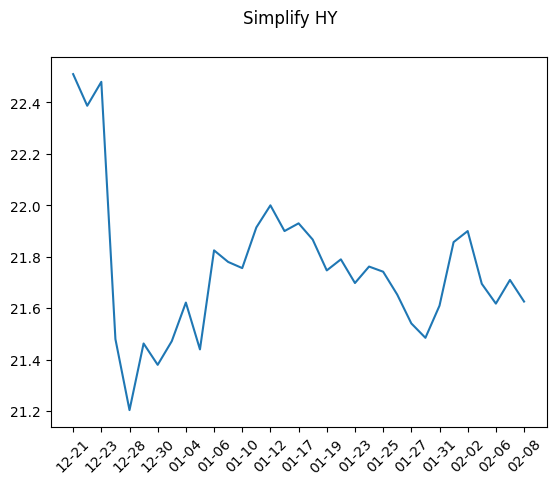

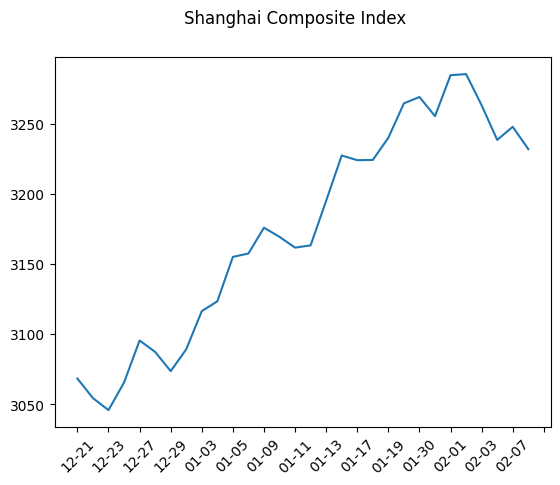

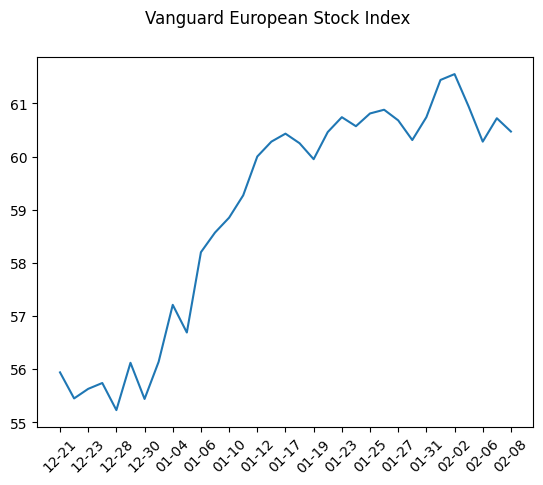

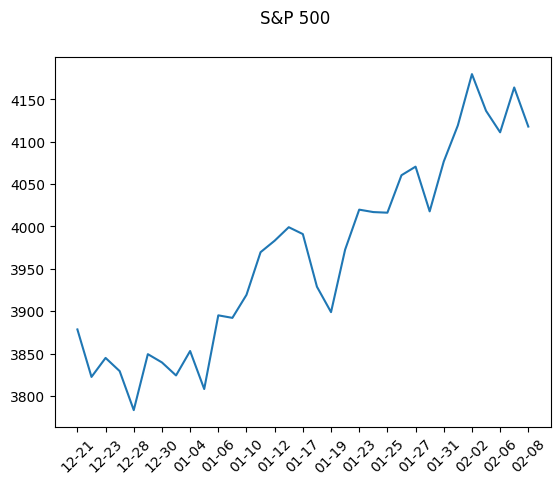

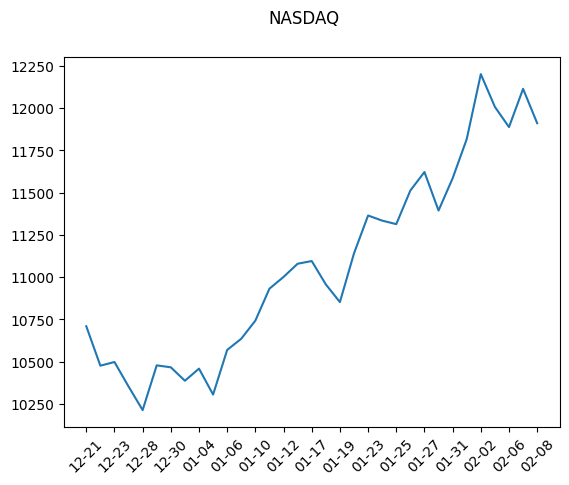

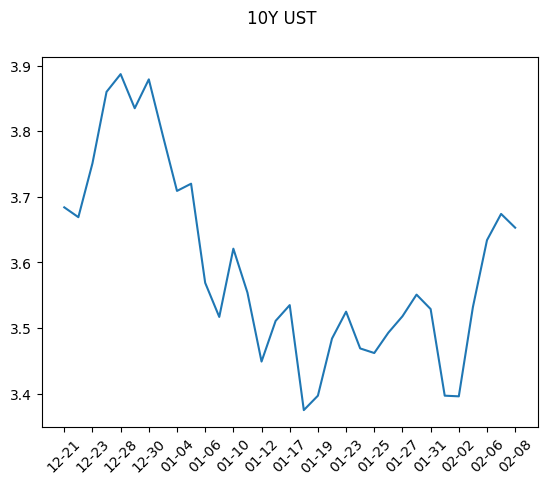

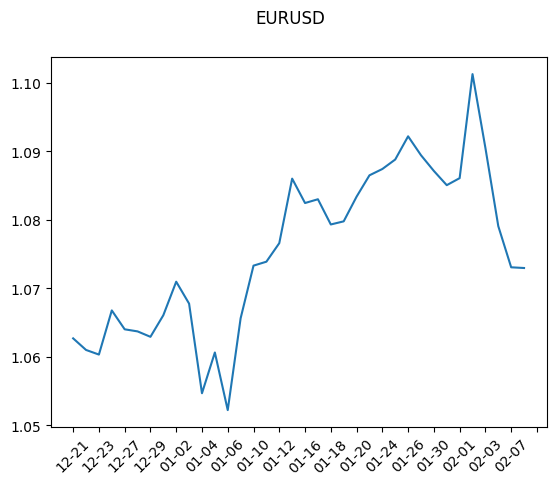

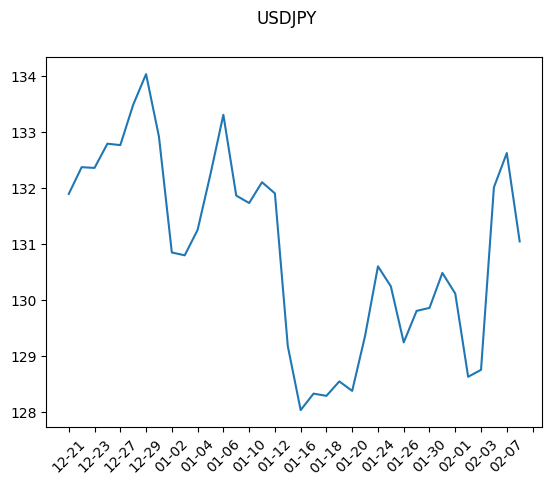

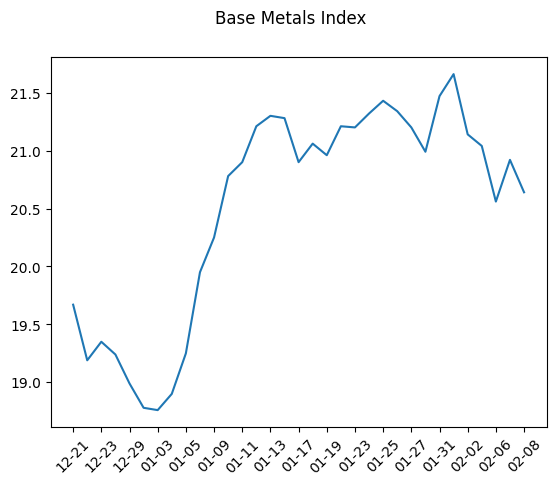

In [42]:
# Making and saving graphs for items in combolist
for combo in comboslist:
    imager(combo)

In [43]:
# Function to create graph for a ticker, label it by given name, then save it for future use from FRED
def FREDimager(combo):
    # Saving given ticker to variable
    ticker = combo[0]
    # Saving given name to variable
    name = combo[1]
    # Downloading data from FRED
    data = pd.DataFrame(pdr.get_data_fred(ticker))
    # Reassigning index
    data.index = data.index.date
    # Getting rid of all values outside of desired range
    from datetime import date
    data = data.loc[date.today()-timedelta(days_back):]
    # Creaing copy of dates
    data['copy'] = data.index
    # Converting copy to string date form
    data['copy'] = data['copy'].apply(lambda x: x.strftime('%m-%d'))
    # Resetting graph to not plot each security on one graph
    plt.figure()
    # Plotting data
    plt.plot(data['copy'], data[ticker])
    # Setting date rotation
    plt.xticks(rotation=45)
    # Minimizing number of dates
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
    # Labelling graph
    plt.suptitle(name)
    # Removing spaces from name
    name = name.replace(" ","")
    # Saving image
    plt.savefig(name)

In [44]:
# List of FRED tickers and names to be used in message
FREDcomboslist = [['T10Y2Y','USYC2Y10'],['DCOILWTICO','WTI Crude'],['MORTGAGE30US','30Y Mortgage']]

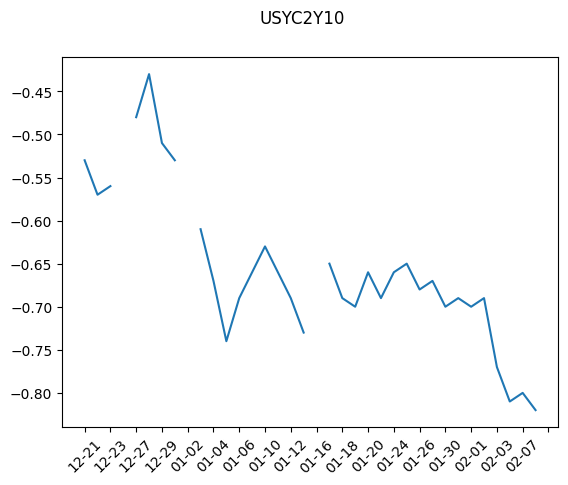

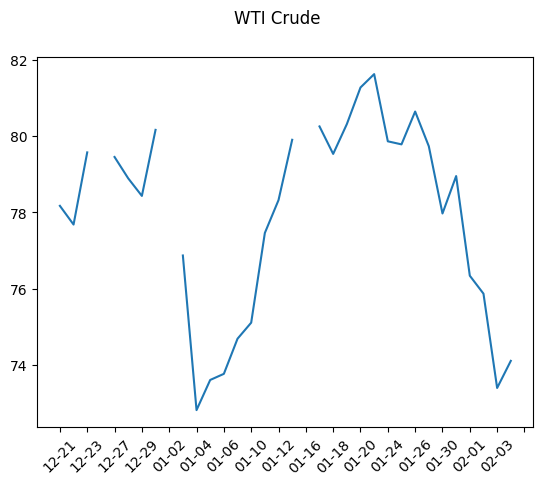

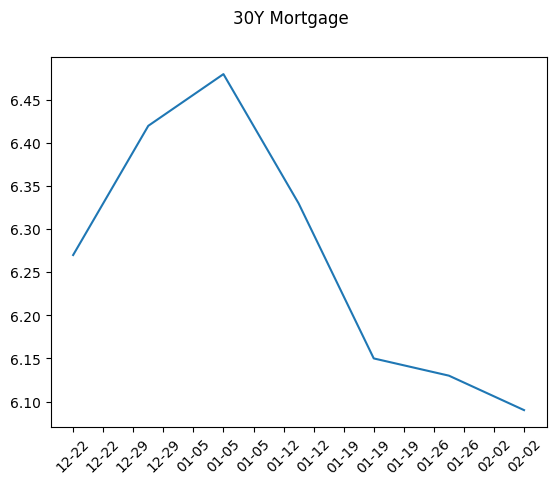

In [45]:
# Making and saving graphs for items in FREDcomboslist
for combo in FREDcomboslist:
    FREDimager(combo)

In [46]:
os.chdir('/Users/dansabra/Documents/GitHub/EmailsProject/Images/')
# Making list of files in Images folder
image_files = os.listdir()
# Removing phantom value
if '.ipynb_checkpoints' in image_files:
    image_files.remove('.ipynb_checkpoints')

In [47]:
if '.DS_Store' in image_files:
    image_files.remove('.DS_Store')

In [48]:
# Empty dictionary
image_inserter = {}

In [49]:
# Adding keys by image name to dictionary where values equal image data 
for x in image_files:
    image_inserter[x[:x.find('.')]] = ('<html><body><h1></h1><img src="cid:'+x+'" width="200" height = "150" alt="inline image"></body></html>')

In [50]:
# Function to get data from image saved to computer to later include in message
def filer(localpath):
    with open(localpath, 'rb') as f:
        image_data = f.read()
        return image_data

In [51]:
# List for image data
MIMEImages = []
# Looping through dictionary
for x in image_files:
    # Applying filer function
    image = MIMEImage(filer(x), name=x)
    # Adding headers
    image.add_header('Content-ID', '<' + x + '>')
    image.add_header('Content-Disposition', 'inline', filename=x)
    # Adding image data to list
    MIMEImages.append(image)

In [52]:
# Downloading S&P 500 data for message
data = pdr.get_data_yahoo('^GSPC', start=startdate, end=enddate, interval = '60m')
# Finding last S&P 500 closing price
last_close = round(list(data[-1:]['Close'])[0],2)
# Saving S&P 500 overnight % change to variable
SP_Prediction = outcomesframe.iloc[0,1]
# Finding predicted opening price
opening_price = last_close * (1+SP_Prediction/100)

[*********************100%***********************]  1 of 1 completed


In [53]:
# Creating HTML message
message = (
"""
<html>
  <body>
    <p>Good Morning Dan!</p>
    <p>Today, our email-reading algorithm predicts that the S&P 500 will open at """ + str(round(opening_price,2)) + """, which is """ + str(SP_Prediction) + """%""" + glt(SP_Prediction) + """ the previous market close of """ + str(last_close) + """.</p>
    <p>Here is how Global Equity Markets have moved over the past """ + str(days_back) + """ days:</p>
    <div style="display: flex;">
      <img src="cid:S&P500.png" width="200" height = "150"alt="image1">
      <img src="cid:NASDAQ.png" width="200" height = "150"alt="image2">
      <img src="cid:VanguardEuropeanStockIndex.png" width="200" height = "150"alt="image3">      
      <img src="cid:ShanghaiCompositeIndex.png" width="200" height = "150"alt="image4">    
    </div>
    <p>A look at Fixed Income over the past """ + str(days_back) + """ days:</p>
    <div style="display: flex;">
      <img src="cid:USYC2Y10.png" width="200" height = "150"alt="image1">
      <img src="cid:10YUST.png" width="200" height = "150"alt="image2">
      <img src="cid:30YMortgage.png" width="200" height = "150"alt="image3">
      <img src="cid:SimplifyHY.png" width="200" height = "150"alt="image4">
    </div>
    <p>FX over the same time period:</p> 
      <img src="cid:EURUSD.png" width="200" height = "150"alt="image1">
      <img src="cid:USDJPY.png" width="200" height = "150"alt="image2">
      <img src="cid:GBPUSD.png" width="200" height = "150"alt="image3">
      <img src="cid:USDAUD.png" width="200" height = "150"alt="image4">
    <p>Last but not least, commodities:</p> 
      <img src="cid:WTICrude.png" width="200" height = "150"alt="image1">
      <img src="cid:NaturalGas.png" width="200" height = "150"alt="image2">   
      <img src="cid:BaseMetalsIndex.png" width="200" height = "150"alt="image3">  
      <img src="cid:Bitcoin.png" width="200" height = "150"alt="image4">   
    <p>Here are the predictions from our Ridge-Regression email-reading models:</p>
    <table border=".1">
      <tr>
        <td>Target</td>
        <td>Prediction</td>
        <td>R-squared</td>
      </tr>
      <tr>
        <td>"""+str(outcomesframe.iloc[0,0]) + """</td>
        <td>"""+str(round(outcomesframe.iloc[0,1],2)) + """%</td>
        <td>"""+str(round(outcomesframe.iloc[0,2],2))+"""</td>
      </tr>
      <tr>
        <td>"""+str(outcomesframe.iloc[1,0]) + """</td>
        <td>"""+str(round(outcomesframe.iloc[1,1],2)) + """%</td>
        <td>"""+str(round(outcomesframe.iloc[1,2],2))+"""</td>
      </tr>
      <tr>
        <td>"""+str(outcomesframe.iloc[2,0]) + """</td>
        <td>"""+str(round(outcomesframe.iloc[2,1],2)) + """%</td>
        <td>"""+str(round(outcomesframe.iloc[2,2],2))+"""</td>
      </tr>  
      <tr>
        <td>"""+str(outcomesframe.iloc[3,0]) + """</td>
        <td>"""+str(round(outcomesframe.iloc[3,1],2)) + """%</td>
        <td>"""+str(round(outcomesframe.iloc[3,2],2))+"""</td>
      </tr> 
    </table>
    <p>Have a great """ + day + """!</p>
  </body>
</html>
"""
)

In [54]:
# Sending email
send_message(service, "danjsabra@gmail.com", str(today) + " Email Analysis", message, [])

{'id': '18636a1c9f9bcc4f',
 'threadId': '18636a1c9f9bcc4f',
 'labelIds': ['UNREAD', 'SENT', 'INBOX']}